# <center>Concentration de CO2 dans l'atmosphère depuis 1958<center>

## <center>Rémy MARION<center>

## <center>Avril 2020<center>

### 1. Préambule

Dès 1958, Charles David Keeling a débuté la mesure précise du taux de CO2 dans l'atmosphère à l'observatoire de Mauna Loa, Hawaii, États-Unis.  
Ces mesures, qui continuent aujourd'hui, ont permis de montrer une évolution tout au long des années du taux de CO2 dans l'hémisphère Nord. Celle-ci étant provenant du cycle de vie des plantes.  
De même, ces données ont montrés une évolution continue du taux de CO2 dans l'atmosphère depuis 1958.

### 2. Travail à faire

Le but de l'exercide est de réaliser un document computationnel pour :
* Réaliser un graphique qui montrera une oscillation périodique superposée à une évolution systématique plus lente.
* Séparer ces deux phénomènes. Caractériser l'oscillation périodique et proposer un modèle simple de la contribution lente
* Estimer ses paramètres et tenter une extrapolation jusqu'à 2025 (dans le but de pouvoir valider le modèle par des observations futures).
* Déposer dans FUN le résultat.

### 3. Base de données

Les données sont disponibles sur le site Web de l'institut Scripps à l'adresse suivante:  
https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html

Pour notre étude, nous prendrons les relevés hebdomadaires : *weekly_in_situ_co2_mlo.csv* que l'on peut télécharger à l'adresse suiavnte : https://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo.html

Nous travaillerons sur une base locale (copiée sur le serveur *Jupyter* de l'INRIA) téléchargée le 13 avril 2020.
La totalité des documents nécessaires à cette étude seront committés sur le serveur *GitLab* de l'INRIA.

### 4. Vérification de la base de données

#### a. Exploration des données

Nous commencerons par analyser le contenu du fichier de données (fichier structuré *CSV*) pour ensuite faire un premier tracé de l'ensemble de la base de données.  
Nous utiliserons les libraries *pandas* et *matplotlib* pour *python 3.6*.

In [1]:
# Import des librairies
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Chargement de la base de données (CSV)
# Les lignes de commentaires sont ignorées
# Le séparateur de champs utilisé dans la base de données est la virgule (,)
# La colonne des dates est parsé et mise en index
date_parser = lambda dates: [pd.datetime.strptime(d, '%Y-%m-%d') for d in dates]

data = pd.read_csv('weekly_in_situ_co2_mlo.csv', sep=',', comment='"', header=None,
                   names=["date", "CO2"])
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# Les dates sont passées à l'index du dataframe
data.set_index('date', inplace=True)
data.shape

(3156, 1)

Les 44 premières lignes de commentaires du fichier brut n'ont pas été prises en compte (commande `comment='"'`).  
La base de données est composée de 3156 mesures et de 2 colonnes :
* date : date de relevé. Avec un relevé par semaine.
* CO2 : concentration de CO2 en *ppm*.

In [3]:
# Affichage partiel de la base de données mise en forme
data.head(5)

CO2
date              
1958-03-29  316.19
1958-04-05  317.31
1958-04-12  317.69
1958-04-19  317.58
1958-04-26  316.48

Text(0,0.5,"Concentration de CO2 dans l'atmosphère [$ppm$]")

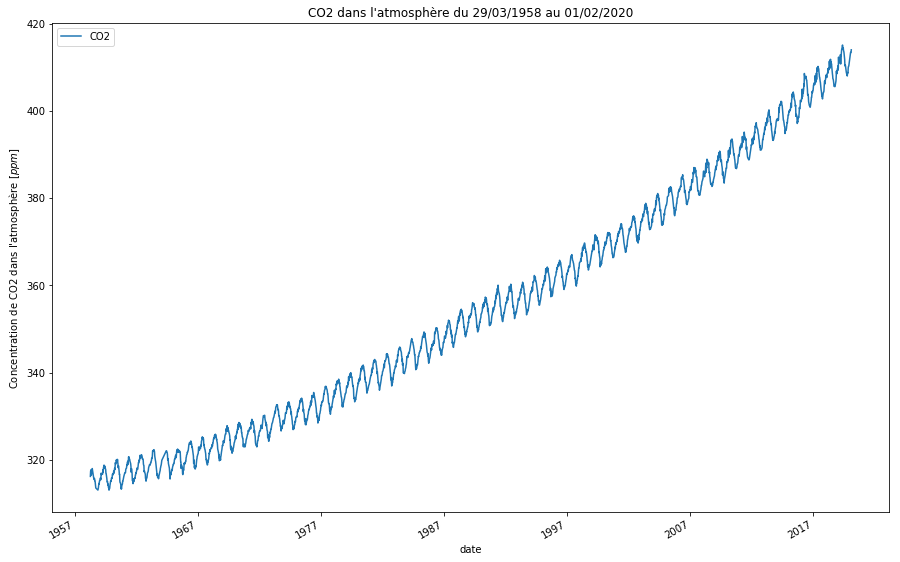

In [4]:
# Graph de la base de données complètes
ax = data.plot(figsize=(15,10), title="CO2 dans l'atmosphère du 29/03/1958 au 01/02/2020")

# Données du graph
ax.set_title("CO2 dans l'atmosphère du 29/03/1958 au 01/02/2020")
ax.set_ylabel("Concentration de CO2 dans l'atmosphère [$ppm$]")
#plt.show()

L'inspection visuelle de la base de données complète montre que le fichier est bien formé et ne semble pas comporter pas de valeurs manquantes ou aberrantes.  

Nous pouvons constater dès à présent les 2 composantes du graphique : une oscillation périodique d'une année superposée à une composante évolutive continue et lente.  
Cette dernière ne semble pas linéaire.

#### b. Vérification de la "structure" de la base de données

Avant d'aller plus loin dans l'analyse, vérifions avec un code de validation la robustesse de la base de données. Nous vérifions la présence de valeurs manquantes et le type des variables (date, float).

In [5]:
# Isolation des lignes comportant des données absentes
data[pd.isnull(data).any(axis=1)].count()

CO2    0
dtype: int64

Il n'y a aucune valeur manquante.

In [6]:
# Vérification du type de la variable CO2
data.dtypes

CO2    float64
dtype: object

In [7]:
# Vérification du type de l'index
data.index.dtype

dtype('<M8[ns]')

Les dates passées à l'index du dataframe est du type `<M8[ns]`. C'est bien un type `datetime64`.

Nous pouvons considérer que la base de données est cohénrente. L'analyse est donc possible.

### 5. Analyse des données

#### a. Mise en évidence des oscillations et mouvements dans les mesures

Dans le paragraphe *4.a*, nous avons déjà pu remarquer une oscillation périodique couplée à une évolution continue du taux de CO2 dans l'atmosphère.  
Voyons l'évolution du taux de CO2 de manière plus précise avec une sequence de 10 ans (par exemple du 15/08/2000 au 15/08/2010) et le détail sur deux années distinctes. Une au début des mesures (du 15/08/1960 au 15/08/1961) et une autre à la fin (du 15/08/2015 au 15/05/2016).

In [8]:
# Définition des périodes à afficher
mask_10y = (data.index > '2000-08-15') & (data.index <= '2010-08-15')
mask1_1y = (data.index > '1960-08-15') & (data.index <= '1961-08-15')
mask2_1y = (data.index > '2015-08-15') & (data.index <= '2016-08-15')

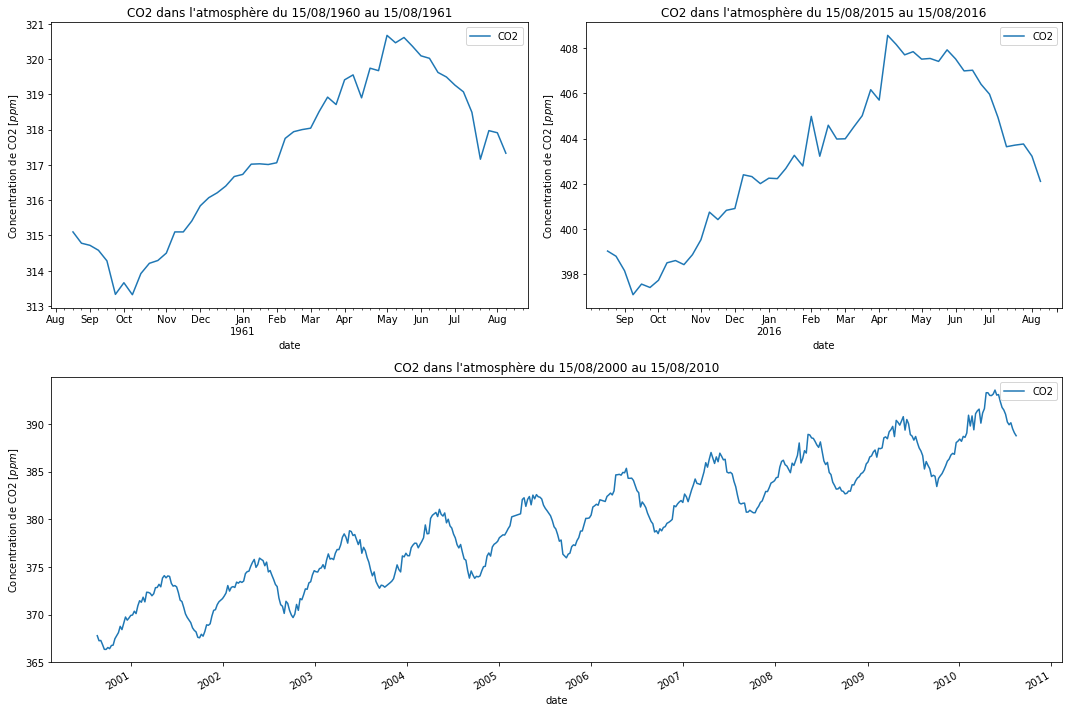

In [9]:
# Graphs de 2 périodes différentes de 1 an
# Graph d'une période de 10 ans
# La base de chaques cycles a été prie au 15 août (comme la base mensuelle de l'institut Scripps)
fig = plt.figure()

# Définition des axes
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)

# Titres des graphs
ax1.set_title("CO2 dans l'atmosphère du 15/08/1960 au 15/08/1961")
ax2.set_title("CO2 dans l'atmosphère du 15/08/2015 au 15/08/2016")
ax3.set_title("CO2 dans l'atmosphère du 15/08/2000 au 15/08/2010")

# Labels des axes
ax1.set_ylabel("Concentration de CO2 [$ppm$]")
ax2.set_ylabel("Concentration de CO2 [$ppm$]")
ax3.set_ylabel("Concentration de CO2 [$ppm$]")

# Graphs
data[mask1_1y].plot(ax=ax1, figsize=(15,10))
data[mask2_1y].plot(ax=ax2, figsize=(15,10))
data[mask_10y].plot(ax=ax3, figsize=(15,10))

# Optimisation de l'espacement entre les graphs
fig.tight_layout()

Nous constatons que le taux de CO2 dans l'atmosphère suit une évolution quasi-sinusoidale sur une année. La contribution lente suit quand à elle une tendance qui semble quadratique (voir graphique 4.a).